In [1]:
##########################################
#  STEP 1. IMPORTS & GLOBAL CONFIG       #
##########################################
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, f1_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import pickle 
import speech_recognition as sr
from transformers import BertTokenizer, BertModel, TFBertModel
from tensorflow.keras.optimizers import Adam
import torch

# For reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/Users/shreyanandini/Desktop/Stress Level Detection From Speech/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/shreyanandini/Desktop/Stress Level Detection From Speech/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Directory where your data is located (adjust as needed)
BASE_DIR = r"/Users/shreyanandini/Desktop/Stress Level Detection From Speech/Audio_Speech_Actors_01-24"
total_files = sum(len(files) for _, _, files in os.walk(BASE_DIR))

print(f"Total number of files: {total_files}")

Total number of files: 1421


In [3]:
#data_df.to_csv("audio_to_transcript.csv")
data_df = pd.read_csv("audio_to_transcript.csv")

In [4]:
def map_emotion_to_stress(e):
    """
    In your dataset, 4/6 = high stress -> 2, 
                     5/7 = low stress -> 1,
                    else 0 = no stress
    """
    if e in [4,6]:
        return 2
    elif e in [5,7]:
        return 1
    else:
        return 0

data_df['stress_label'] = data_df['emotion'].apply(map_emotion_to_stress)

print(data_df.head())
print("Total files:", len(data_df))

# Shuffle dataframe
data_df = data_df.sample(frac=1.0, random_state=RANDOM_SEED).reset_index(drop=True)

   Unnamed: 0.1  Unnamed: 0  \
0             0          51   
1             1         289   
2             2         677   
3             3        1005   
4             4         367   

                                           file_path  src  actor  gender  \
0  /Users/shreyanandini/Desktop/Stress Level Dete...    1      1    male   
1  /Users/shreyanandini/Desktop/Stress Level Dete...    1      5    male   
2  /Users/shreyanandini/Desktop/Stress Level Dete...    1     12  female   
3  /Users/shreyanandini/Desktop/Stress Level Dete...    1     18  female   
4  /Users/shreyanandini/Desktop/Stress Level Dete...    1      7    male   

   intensity  statement  repeat  emotion                    transcript  \
0          1          1       1        6  dogs are sitting by the door   
1          0          0       1        1  kids are talking by the door   
2          0          0       0        4  kids are talking by the door   
3          0          0       1        6   can you talking b

In [5]:
##########################################
#  STEP 3. TRAIN/VAL/TEST SPLIT          #
##########################################
# Splitting data_df into Training and Temporary Sets(temp_df)
train_df, temp_df = train_test_split(
    data_df,
    test_size=0.2,
    stratify=data_df['stress_label'],
    random_state=RANDOM_SEED
)
# Splitting the Temporary Set into Validation and Test Sets
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['stress_label'],
    random_state=RANDOM_SEED
)

print(f"Train size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 1136, Val size: 142, Test size: 142


In [6]:
import tensorflow as tf
import numpy as np
import librosa
from transformers import TFBertModel, BertTokenizer

SAMPLE_RATE = 16000       # Sampling rate
MAX_DURATION_SEC = 120.0  # Maximum audio duration
N_MFCC = 40               # Number of MFCC features
FIXED_FRAMES = 200        # Fixed number of time frames for padding/truncation
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

def load_audio(file_path, sr=SAMPLE_RATE, max_duration=MAX_DURATION_SEC):
    y, sr = librosa.load(file_path, sr=sr, duration=max_duration)
    return y, sr

def extract_mfcc(file_path, sr=SAMPLE_RATE, n_mfcc=N_MFCC):
    y, sr = load_audio(file_path, sr=sr, max_duration=MAX_DURATION_SEC)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)  # shape: (n_mfcc, time_frames)
    if mfcc.shape[1] < FIXED_FRAMES:
        pad_width = FIXED_FRAMES - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :FIXED_FRAMES]
    return np.expand_dims(mfcc, axis=-1)  # Add channel dimension

def extract_bert_embedding(text):
    if not text or text == "Could not process audio transcription.":
        return np.zeros((768,))
    tokens = tokenizer(text, return_tensors="tf", padding=True, truncation=True, max_length=512)
    outputs = bert_model(**tokens)
    return tf.squeeze(outputs.last_hidden_state[:, 0, :], axis=0).numpy()

def build_features_and_labels(df):
    X_audio_list, X_text_list, y_list = [], [], []
    for _, row in df.iterrows():
        file_path = row['file_path']
        transcript = row['transcript']
        label = row['stress_label']

        if not os.path.isfile(file_path):
            continue

        mfcc = extract_mfcc(file_path)
        bert_embedding = extract_bert_embedding(transcript)

        X_audio_list.append(mfcc)
        X_text_list.append(bert_embedding)
        y_list.append(label)

    X_audio_arr = np.array(X_audio_list, dtype=np.float32)
    X_text_arr = np.array(X_text_list, dtype=np.float32)
    y_arr = np.array(y_list, dtype=np.int64)

    return X_audio_arr, X_text_arr, y_arr

# Example usage:
X_train_audio, X_train_text, y_train = build_features_and_labels(train_df)
X_val_audio, X_val_text, y_val = build_features_and_labels(val_df)
X_test_audio, X_test_text, y_test = build_features_and_labels(test_df)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
# ##########################################
# #  STEP 4. FEATURE EXTRACTION (MFCC)     #
# ##########################################
# SAMPLE_RATE = 16000       # or 22050
# MAX_DURATION_SEC = 120.0    # we’ll pad/truncate to 5s
# N_MFCC = 40
# FIXED_FRAMES = 200        # number of frames along time axis
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert_model = BertModel.from_pretrained('bert-base-uncased')

# def load_audio(file_path, sr=SAMPLE_RATE, max_duration=MAX_DURATION_SEC):
#     # Load up to max_duration seconds
#     y, sr = librosa.load(file_path, sr=sr, duration=max_duration)
#     return y, sr

# def extract_mfcc(file_path, sr=SAMPLE_RATE, n_mfcc=N_MFCC):
#     y, sr = load_audio(file_path, sr=sr, max_duration=MAX_DURATION_SEC)
#     mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)  # shape: (n_mfcc, time_frames)
#     # Pad or truncate to FIXED_FRAMES along the time axis
#     if mfcc.shape[1] < FIXED_FRAMES:
#         pad_width = FIXED_FRAMES - mfcc.shape[1]
#         mfcc = np.pad(mfcc, ((0,0), (0,pad_width)), mode='constant')
#     else:
#         mfcc = mfcc[:, :FIXED_FRAMES]
   
#     return mfcc
# def extract_bert_embedding(text):
#     if not text or text == "Could not process audio transcription.":
#         return np.zeros((768,))
#     tokens = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
#     with torch.no_grad():
#         outputs = bert_model(**tokens)
#     return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

# def build_features_and_labels(df):
#     X_audio_list, X_text_list, y_list = [], [], []
#     for _, row in df.iterrows():
#         file_path = row['file_path']
#         transcript = row['transcript']
#         label = row['stress_label']

#         if not os.path.isfile(file_path):
#             continue

#         mfcc = extract_mfcc(file_path)
#         mfcc = np.expand_dims(mfcc, axis=-1)
#         bert_embedding = extract_bert_embedding(transcript)

#         X_audio_list.append(mfcc)
#         X_text_list.append(bert_embedding)
#         y_list.append(label)

#     X_audio_arr = np.array(X_audio_list, dtype=np.float32)
#     X_text_arr = np.array(X_text_list, dtype=np.float32)
#     y_arr = np.array(y_list, dtype=np.int64)

#     return X_audio_arr, X_text_arr, y_arr

# X_train_audio, X_train_text, y_train = build_features_and_labels(train_df)
# X_val_audio, X_val_text, y_val = build_features_and_labels(val_df)
# X_test_audio, X_test_text, y_test = build_features_and_labels(test_df)

# # Build train/val/test feature sets
# # print("Extracting features for TRAIN set...")
# # X_train, y_train = build_features_and_labels(train_df)

# # print("Extracting features for VAL set...")
# # X_val, y_val = build_features_and_labels(val_df)

# # print("Extracting features for TEST set...")
# # X_test, y_test = build_features_and_labels(test_df)

# # print("X_train shape:", X_train.shape)
# # print("y_train shape:", y_train.shape)


In [ ]:
##########################################
#  STEP 5. BUILD THE CNN MODEL           #
##########################################
# num_classes = 3  # no-stress, low-stress, high-stress
# model = models.Sequential([
#     layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu',
#                   input_shape=(N_MFCC, FIXED_FRAMES, 1)),
#     layers.MaxPooling2D(pool_size=(2,2)),
   
#     layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
   
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(num_classes, activation='softmax')
# ])
# model.compile(
#     optimizer='adam',
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )
# model.summary()

In [14]:
from tensorflow.keras import layers, models
num_classes = 3
# Input layers
audio_input = tf.keras.Input(shape=(N_MFCC, FIXED_FRAMES, 1), name="audio_input")
text_input = tf.keras.Input(shape=(768,), name="text_input")  # 768 is the BERT embedding size

# Audio branch
audio_model = layers.Conv2D(32, (3, 3), activation="relu")(audio_input)
audio_model = layers.MaxPooling2D((2, 2))(audio_model)
audio_model = layers.Flatten()(audio_model)
audio_model = layers.Dense(128, activation="relu")(audio_model)

# Text branch
text_model = layers.Dense(128, activation="relu")(text_input)

# Combine branches
combined = layers.concatenate([audio_model, text_model])
combined = layers.Dense(64, activation="relu")(combined)
combined = layers.Dropout(0.3)(combined)
output = layers.Dense(num_classes, activation='softmax')(combined)  # Binary classification

# Final model
model = tf.keras.Model(inputs=[audio_input, text_input], outputs=output)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


# ##########################################
# #  STEP 5. BUILD THE CNN MODEL           #
# ##########################################
# num_classes = 3
# audio_input = Input(shape=(N_MFCC, FIXED_FRAMES, 1), name="audio_input")
# audio_model = layers.Conv2D(16, (3, 3), activation='relu')(audio_input)
# audio_model = layers.MaxPooling2D((2, 2))(audio_model)
# audio_model = layers.Conv2D(32, (3, 3), activation='relu')(audio_model)
# audio_model = layers.MaxPooling2D((2, 2))(audio_model)
# audio_model = layers.Flatten()(audio_model)

# text_input = Input(shape=(768,), name="text_input")
# text_model = layers.Dense(128, activation='relu')(text_input)
# text_model = layers.Dropout(0.3)(text_model)

# fusion = layers.Concatenate()([audio_model, text_model])
# fusion = layers.Dense(64, activation='relu')(fusion)
# fusion = layers.Dropout(0.3)(fusion)
# output = layers.Dense(num_classes, activation='softmax')(fusion)

# model = models.Model(inputs=[audio_input, text_input], outputs=output)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ audio_input         │ (None, 40, 200,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 38, 198,   │        320 │ audio_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 19, 99,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 60192)     │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │  7,704,704 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     98,432 │ text_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 256)       │          0 │ dense_6[0][0],    │
│ (Concatenate)       │                   │            │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │     16,448 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 3)         │        195 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,820,099 (29.83 MB)

 Trainable params: 7,820,099 (29.83 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ##########################################
# #  STEP 5. BUILD THE CNN MODEL           #
# ##########################################
# num_classes = 3
# audio_input = Input(shape=(N_MFCC, FIXED_FRAMES, 1), name="audio_input")
# audio_model = layers.Conv2D(16, (3, 3), activation='relu')(audio_input)
# audio_model = layers.MaxPooling2D((2, 2))(audio_model)
# audio_model = layers.Conv2D(32, (3, 3), activation='relu')(audio_model)
# audio_model = layers.MaxPooling2D((2, 2))(audio_model)
# audio_model = layers.Flatten()(audio_model)

# text_input = Input(shape=(768,), name="text_input")
# text_model = layers.Dense(128, activation='relu')(text_input)
# text_model = layers.Dropout(0.3)(text_model)

# fusion = layers.Concatenate()([audio_model, text_model])
# fusion = layers.Dense(64, activation='relu')(fusion)
# fusion = layers.Dropout(0.3)(fusion)
# output = layers.Dense(num_classes, activation='softmax')(fusion)

# model = models.Model(inputs=[audio_input, text_input], outputs=output)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ audio_input         │ (None, 40, 200,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 38, 198,   │        160 │ audio_input[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 19, 99,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 17, 97,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 48, 32) │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     98,432 │ text_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 12288)     │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 12416)     │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │    794,688 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 3)         │        195 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 898,115 (3.43 MB)

 Trainable params: 898,115 (3.43 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:

num_classes = 3
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_val_one_hot = to_categorical(y_val, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

In [16]:
# Train the model
history = model.fit(
    x={"audio_input": X_train_audio, "text_input": X_train_text},
    y=y_train_one_hot,
    validation_data=(
        {"audio_input": X_val_audio, "text_input": X_val_text},
        y_val_one_hot,
    ),
    batch_size=32,
    epochs=20
)

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(
    {"audio_input": X_test_audio, "text_input": X_test_text}, y_test_one_hot
)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.3887 - loss: 36.9909 - val_accuracy: 0.4718 - val_loss: 3.9046
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4895 - loss: 2.5901 - val_accuracy: 0.5775 - val_loss: 0.9156
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5404 - loss: 0.8894 - val_accuracy: 0.5211 - val_loss: 0.9471
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6000 - loss: 0.8983 - val_accuracy: 0.5000 - val_loss: 0.9632
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6056 - loss: 0.7846 - val_accuracy: 0.6197 - val_loss: 0.8731
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6803 - loss: 0.6588 - val_accuracy: 0.5845 - val_loss: 0.9603
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6707 - loss: 0.7209 - val_accuracy: 0.6338 - val_loss: 0.8354
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7254 - loss: 0.6168 - val_accuracy: 0.6408 - 

In [ ]:
##########################################
#  STEP 6. TRAIN THE MODEL               #
##########################################
EPOCHS = 50     # adjust as needed
BATCH_SIZE = 32

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',      # Metric to monitor (e.g., validation loss)
    patience=5,              # Number of epochs to wait before stopping
    restore_best_weights=True # Restore the best weights
)

# Train the model with early stopping
history = model.fit(
    [X_train_audio, X_train_text], y_train_one_hot,
    validation_data=([X_val_audio, X_val_text], y_val_one_hot),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping]  # Add the early stopping callback here
)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3992 - loss: 5.3759 - val_accuracy: 0.5352 - val_loss: 1.0254
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4944 - loss: 1.0066 - val_accuracy: 0.5211 - val_loss: 1.0148
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5132 - loss: 0.9594 - val_accuracy: 0.5211 - val_loss: 0.9994
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5642 - loss: 0.8886 - val_accuracy: 0.5211 - val_loss: 0.9194
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6547 - loss: 0.7204 - val_accuracy: 0.5775 - val_loss: 0.8533
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7342 - loss: 0.6082 - val_accuracy: 0.6056 - val_loss: 0.7728
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7577 - loss: 0.5193 - val_accuracy: 0.6408 - val_loss: 0.7920
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8117 - loss: 0.4323 - val_accuracy: 0.6831 - v

In [17]:
##########################################
#  STEP 7. EVALUATION & METRICS          #
##########################################
test_loss, test_acc = model.evaluate([X_test_audio, X_test_text], y_test_one_hot, verbose=0)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

y_pred_proba = model.predict([X_test_audio, X_test_text])
y_pred = np.argmax(y_pred_proba, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Stress', 'Low Stress','High Stress']))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Test Loss: 1.9172 | Test Accuracy: 0.5634
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Classification Report:
              precision    recall  f1-score   support

   No Stress       0.72      0.46      0.56        67
  Low Stress       0.45      0.89      0.60        37
 High Stress       0.62      0.42      0.50        38

    accuracy                           0.56       142
   macro avg       0.60      0.59      0.55       142
weighted avg       0.62      0.56      0.56       142

Confusion Matrix:
[[31 28  8]
 [ 2 33  2]
 [10 12 16]]


In [18]:
# ---------------------------
# 7. Evaluate
# ---------------------------
loss, acc = model.evaluate([X_test_audio, X_test_text], y_test_one_hot, verbose=0)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc*100:.2f}%")


Test Loss: 1.9172, Test Accuracy: 56.34%


In [19]:
# Flatten MFCC for SVM and Random Forest
def prepare_flat_features(X_audio, X_text):
    X_audio_flat = X_audio.reshape(X_audio.shape[0], -1)  # Flatten MFCC
    X_combined = np.concatenate((X_audio_flat, X_text), axis=1)  # Combine audio and text features
    return X_combined

# Prepare train, validation, and test data
X_train_combined = prepare_flat_features(X_train_audio, X_train_text)
X_val_combined = prepare_flat_features(X_val_audio, X_val_text)
X_test_combined = prepare_flat_features(X_test_audio, X_test_text)

# Train and evaluate SVM
print("Training SVM...")
svm_model = SVC(kernel='rbf', C=1.0, random_state=RANDOM_SEED)
svm_model.fit(X_train_combined, y_train)

print("Evaluating SVM...")
y_pred_svm = svm_model.predict(X_test_combined)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))
print("SVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))
print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"SVM F1 Score: {f1_score(y_test, y_pred_svm, average='weighted'):.4f}")

# Train and evaluate Random Forest
print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
rf_model.fit(X_train_combined, y_train)

print("Evaluating Random Forest...")
y_pred_rf = rf_model.predict(X_test_combined)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Random Forest F1 Score: {f1_score(y_test, y_pred_rf, average='weighted'):.4f}")


Training SVM...
Evaluating SVM...
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.99      0.72        67
           1       0.79      0.51      0.62        37
           2       1.00      0.03      0.05        38

    accuracy                           0.61       142
   macro avg       0.79      0.51      0.46       142
weighted avg       0.74      0.61      0.51       142

SVM Confusion Matrix:
[[66  1  0]
 [18 19  0]
 [33  4  1]]
SVM Accuracy: 0.6056
SVM F1 Score: 0.5145
Training Random Forest...
Evaluating Random Forest...
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.91      0.75        67
           1       0.73      0.65      0.69        37
           2       0.62      0.21      0.31        38

    accuracy                           0.65       142
   macro avg       0.66      0.59      0.58       142
weighted avg       0.65      0.65      0

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


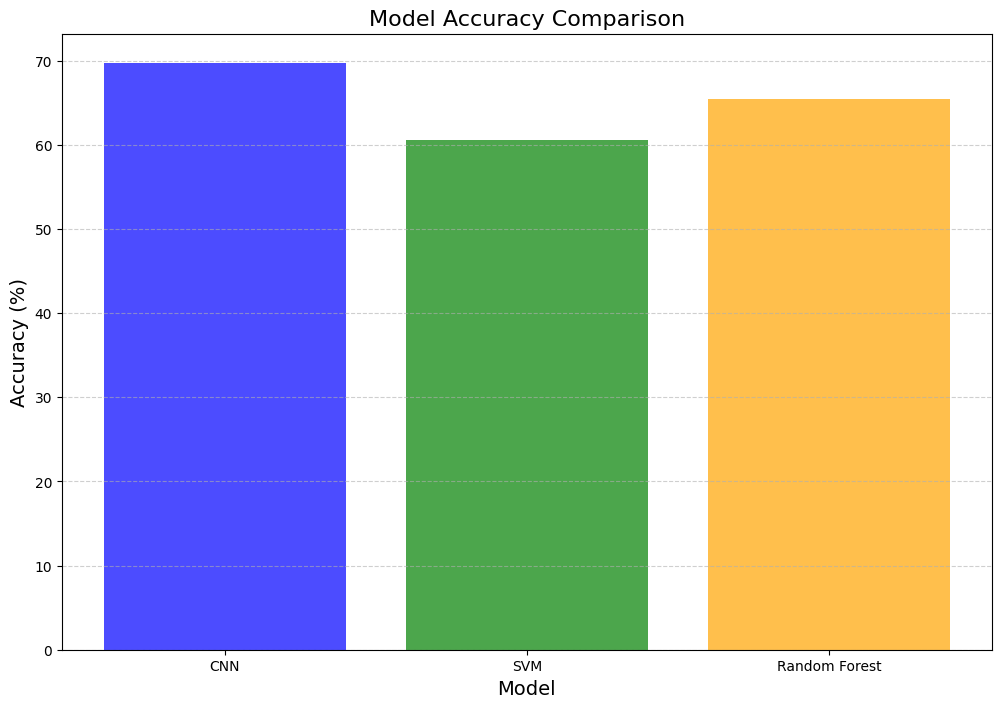

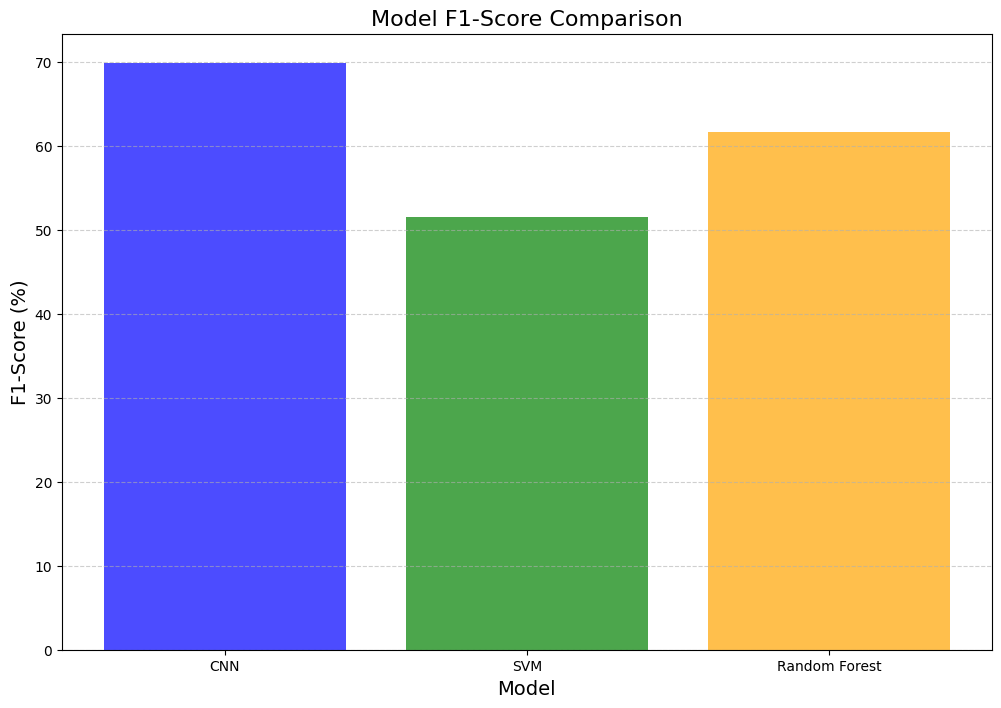

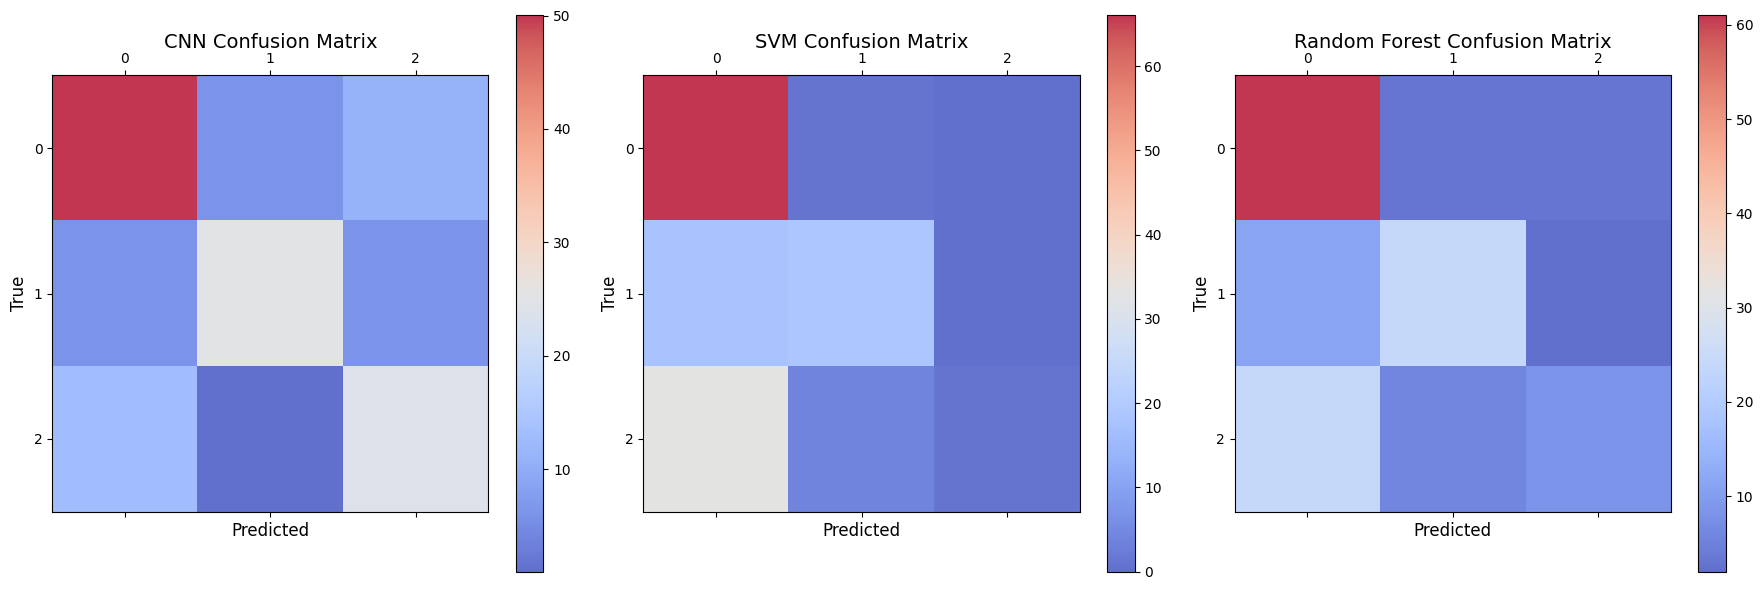

In [16]:
# Rerunning the evaluation and plotting
cnn_predictions = np.argmax(model.predict([X_test_audio, X_test_text]), axis=1)

# Recalculating metrics for CNN
cnn_accuracy = accuracy_score(y_test, cnn_predictions) * 100
cnn_f1_score = f1_score(y_test, cnn_predictions, average='weighted') * 100
cnn_conf_matrix = confusion_matrix(y_test, cnn_predictions)

# SVM and Random Forest metrics are already available
svm_accuracy = accuracy_score(y_test, y_pred_svm) * 100
svm_f1_score = f1_score(y_test, y_pred_svm, average='weighted') * 100
svm_conf_matrix = confusion_matrix(y_test, y_pred_svm)

rf_accuracy = accuracy_score(y_test, y_pred_rf) * 100
rf_f1_score = f1_score(y_test, y_pred_rf, average='weighted') * 100
rf_conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Data for plotting
models = ['CNN', 'SVM', 'Random Forest']
accuracy = [cnn_accuracy, svm_accuracy, rf_accuracy]
f1_scores = [cnn_f1_score, svm_f1_score, rf_f1_score]
conf_matrices = [cnn_conf_matrix, svm_conf_matrix, rf_conf_matrix]

# Plot 1: Accuracy comparison
plt.figure(figsize=(12, 8))
plt.bar(models, accuracy, color=['blue', 'green', 'orange'], alpha=0.7)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.title('Model Accuracy Comparison', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Plot 2: F1-Score comparison
plt.figure(figsize=(12, 8))
plt.bar(models, f1_scores, color=['blue', 'green', 'orange'], alpha=0.7)
plt.xlabel('Model', fontsize=14)
plt.ylabel('F1-Score (%)', fontsize=14)
plt.title('Model F1-Score Comparison', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Plot 3: Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
titles = ['CNN Confusion Matrix', 'SVM Confusion Matrix', 'Random Forest Confusion Matrix']
for i, ax in enumerate(axes):
    cax = ax.matshow(conf_matrices[i], cmap='coolwarm', alpha=0.8)
    fig.colorbar(cax, ax=ax)
    ax.set_title(titles[i], pad=20, fontsize=14)
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    ax.set_xticks(range(num_classes))
    ax.set_yticks(range(num_classes))
plt.tight_layout()
plt.show()


In [17]:

# Assuming `history` is the training history object from model.fit()
# and `loss` and `accuracy` are the test set metrics.

def plot_training_validation_results(history, test_metrics):
    """
    Plot training vs validation results and compare with test set.

    Parameters:
        history: History object from model.fit()
        test_metrics: Tuple (test_loss, test_accuracy)
    """
    test_loss, test_accuracy = test_metrics

    # Extract metrics from the training history
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(1, len(train_loss) + 1)
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label='Train Accuracy', marker='o', color='blue')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o', color='green')
    plt.axhline(y=test_accuracy, color='red', linestyle='--', label='Test Accuracy')
    plt.title('Accuracy per Epoch', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

# Dummy metrics for SVM and Random Forest
# Replace with actual metrics (e.g., train_accuracy, val_accuracy, test_accuracy)
def plot_svm_rf_comparison(train_acc, val_acc, test_acc, model_name):
    """
    Plot a bar chart comparing train, validation, and test accuracies for SVM or RF.

    Parameters:
        train_acc: Training accuracy
        val_acc: Validation accuracy
        test_acc: Test accuracy
        model_name: Name of the model (e.g., 'SVM' or 'Random Forest')
    """
    plt.figure(figsize=(8, 6))
    
    accuracies = [train_acc, val_acc, test_acc]
    labels = ['Train', 'Validation', 'Test']

    plt.bar(labels, accuracies, color=['blue', 'green', 'orange'], alpha=0.7)
    plt.title(f'{model_name} Accuracy Comparison', fontsize=16)
    plt.ylabel('Accuracy (%)', fontsize=14)
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()


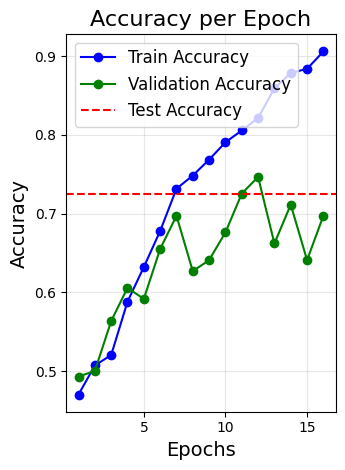

In [ ]:
#plot_training_validation_results(history, (test_loss, acc))

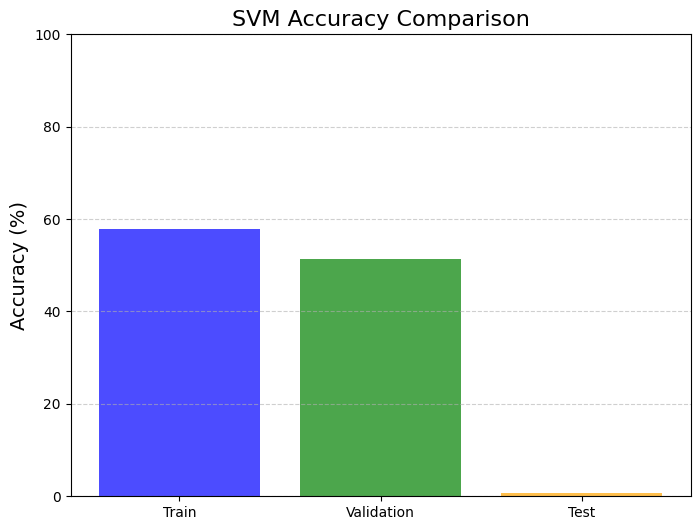

In [ ]:
# train_acc_svm = svm_model.score(X_train_combined, y_train) * 100  # Convert to percentage
# val_acc_svm = svm_model.score(X_val_combined, y_val) * 100  # Convert to percentage
# plot_svm_rf_comparison(train_acc_svm, val_acc_svm, test_acc, "SVM")


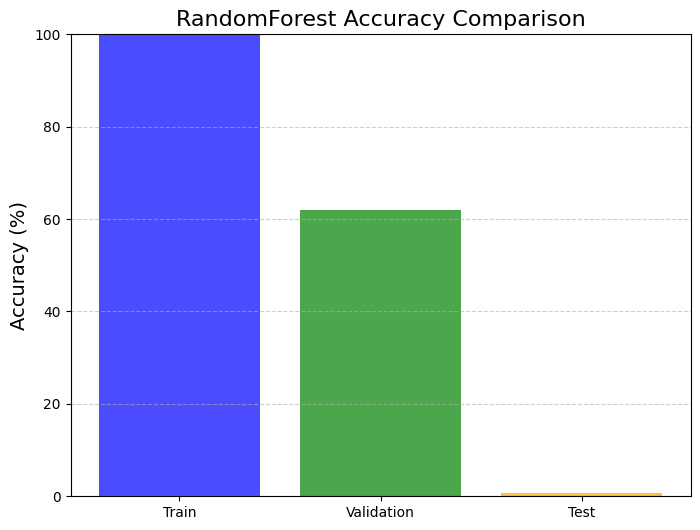

In [ ]:
# train_acc_rf = rf_model.score(X_train_combined, y_train) * 100  # Convert to percentage
# val_acc_rf = rf_model.score(X_val_combined, y_val) * 100  # Convert to percentage
# plot_svm_rf_comparison(train_acc_rf, val_acc_rf, test_acc, "RandomForest")

In [18]:
##########################################
#  STEP 8. SAVE THE MODEL                #
##########################################
# model.save("stress_detector_cnn.h5")
# print("Model saved as stress_detector_cnn.h5")
# Optionally, you can also do:
# joblib.dump(model, "stress_detector_cnn.pkl") 

pickle.dump(model,open('model.pkl','wb'))